In [1]:
import itertools

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

# Question 1
## (a)

In [2]:
import pickle
from torch.utils.data import Dataset, DataLoader


class MnistDataset():
    def __init__(self, X, y, transform_X=lambda x: x):
        assert X.shape[0] == y.shape[0]
        self.X = transform_X(X)
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    
def load_mnist(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)
    
    X_train = torch.tensor(train_data[0], dtype=torch.float).unsqueeze(1)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float).unsqueeze(1)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test


In [10]:
# load data and normalize by dividing the maximum value
X_train, y_train, X_test, y_test = load_mnist('mnist.pkl')
X_train /= torch.max(X_train)
X_test /= torch.max(X_test)

In [16]:
# further split the train to train/validation with 80/20 
X_further_train, X_val, y_further_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

# use MnistDataset class to handle the data
train_data = MnistDataset(X_further_train, y_further_train)
val_data = MnistDataset(X_val, y_val)
test_data = MnistDataset(X_test, y_test)

## (b)

In [60]:
class VAE(nn.Module):
    def __init__(self, in_channels=1, z_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            # conv1, input_channel -> 4
            nn.Conv2d(in_channels, 4, kernel_size=4, padding=1, stride=2), 
            nn.ReLU(), # relu
            # conv2, channel 4 -> 8
            nn.Conv2d(4, 8, kernel_size=4, padding=1, stride=2),  
            nn.ReLU(), # relu
            nn.Conv2d(8, 16, kernel_size=4, padding=1, stride=2),  # conv3, channel 8 -> 16
            nn.ReLU(), # relu
            nn.Conv2d(16, 32, kernel_size=4, padding=1, stride=2), # conv4, channel 16 -> 32
            nn.ReLU(), # relu
            nn.Flatten(), # flatten
        )
        
        # manually calculate the dimension after all convolutions
        dim_after_conv = 2
        hidden_dim = 32 * dim_after_conv * dim_after_conv
        
        # Readout layer is mu
        self.readout_mu = nn.Linear(hidden_dim, z_dim)
        # Readout layer
        self.readout_sigma = nn.Linear(hidden_dim, z_dim)
        
        # You can use nn.ConvTranspose2d to decode
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.Unflatten(1, (32, dim_after_conv, dim_after_conv)),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # transpose-conv, channel 32 -> 16
            nn.ReLU(), # relu
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1), # transpose-conv, channel 16 -> 8
            nn.ReLU(), # relu
            nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1), # transpose-conv, channel 8 -> 4
            nn.ReLU(), # relu
            nn.ConvTranspose2d(4, in_channels, kernel_size=4, stride=2, padding=1), # transpose-conv, channel 4 -> input_channel, which is 1
            nn.Sigmoid(), # use a sigmoid activation to squeeze the outputs between 0 and 1
        )
    
    def reparameterize(self, mu, sigma):
        """
        Reparameterize, i.e. generate a z ~ N(\mu, \sigma)
        """
        # generate epsilon ~ N(0, I)
        # hint: use torch.randn or torch.randn_like
        epsilon = torch.randn_like(sigma)
        # z = \mu + \sigma * \epsilon
        z = mu + sigma * epsilon
        return z

    def encode(self, x):
        # call the encoder to map input to a hidden state vector
        h = self.encoder(x)
        # use the "readout" layer to get \mu and \sigma
        mu = self.readout_mu(h)
        sigma = self.readout_sigma(h)
        return mu, sigma

    def decode(self, z):
        # call the decoder to map z back to x
        return self.decoder(z)

    def forward(self, x):
        mu, sigma = self.encode(x)
        z = self.reparameterize(mu, sigma)
        x_recon = self.decode(z)
        return x_recon, mu, sigma

## (c)

*For debugging*: The `test_kld_loss_func` should output 1.3863

In [61]:
def kld_loss_func(mu, sigma):
    """
    KL-Divergence: KLD = 0.5 * sum(\mu^2 + \sigma^2 - ln(\sigma^2) - 1)
    
    Parameters
    ----------
    mu: torch.Tensor
        Mean vector in the VAE bottleneck region
    sigma: torch.Tensor
        Standard Deviation vector in the VAE bottleneck region
    
    Return
    ------
    kld: torch.Tensor
        KL-Divegence loss (a scalar)
    """
    return 0.5 * torch.sum(mu.pow(2) + sigma.pow(2) - torch.log(sigma.pow(2)) - 1)


def vae_loss_func(recon_x, x, mu, sigma):

    bce_loss = nn.BCELoss(reduction='sum')(recon_x, x)
    kld_loss = kld_loss_func(mu, sigma)

    return bce_loss + kld_loss


def test_kld_loss_func():
    mu = torch.tensor([0.5, 0.5, 1.0])
    sigma = torch.tensor([1.0, 0.5, 0.5])
    print(kld_loss_func(mu, sigma))

test_kld_loss_func()

tensor(1.3863)


In [62]:
import torch.nn.functional as F

class VAETrainer:
    
    def __init__(self, model, learning_rate, batch_size, epoch, l2):
        self.model = model
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        
        self.epoch = epoch
        self.batch_size = batch_size
        

    
    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list = []
        val_loss_list = []
        
        weights = self.model.state_dict()
        lowest_val_loss = np.inf

        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in train_loader:
                batch_importance = 1 / len(train_data)
                # call the model
                X_batch_recon, mu, sigma = self.model(X_batch)
                batch_loss = vae_loss_func(X_batch_recon, X_batch, mu, sigma)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
            
            train_loss_list.append(epoch_loss)
            
            val_loss = self.evaluate(val_data, print_loss=False)
            val_loss_list.append(val_loss)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(x_axis, train_loss_list, label="Train")
            ax.plot(x_axis, val_loss_list, label="Validation")
            ax.set_title("Total Loss")
            ax.set_xlabel("# Epoch")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "val_loss_list": val_loss_list,
        }
    
    def evaluate(self, data, print_loss=True):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size)
        total_loss = 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = 1 / len(data)
                X_batch_recon, mu, sigma = self.model(X_batch)
                batch_loss = vae_loss_func(X_batch_recon, X_batch, mu, sigma)
                total_loss += batch_loss.detach().cpu().item() * batch_importance
        if print_loss:
            print(f"Total Loss: {total_loss}")
        return total_loss

In [63]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
for X_batch, y_batch in train_loader:
    print(X_batch.shape)

torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([12

In [64]:
x, y = next(iter(train_loader))

In [65]:
y.shape

torch.Size([128])

In [66]:
x.shape

torch.Size([128, 1, 32, 32])

In [68]:
vae = VAE()

In [69]:
vae(x)

(tensor([[[[0.5465, 0.5466, 0.5461,  ..., 0.5467, 0.5459, 0.5462],
           [0.5431, 0.5441, 0.5418,  ..., 0.5430, 0.5411, 0.5471],
           [0.5462, 0.5461, 0.5440,  ..., 0.5463, 0.5431, 0.5472],
           ...,
           [0.5431, 0.5445, 0.5424,  ..., 0.5439, 0.5422, 0.5468],
           [0.5462, 0.5462, 0.5440,  ..., 0.5469, 0.5421, 0.5468],
           [0.5446, 0.5432, 0.5440,  ..., 0.5433, 0.5442, 0.5450]]],
 
 
         [[[0.5465, 0.5465, 0.5461,  ..., 0.5467, 0.5459, 0.5462],
           [0.5431, 0.5441, 0.5418,  ..., 0.5430, 0.5411, 0.5471],
           [0.5462, 0.5462, 0.5440,  ..., 0.5463, 0.5431, 0.5472],
           ...,
           [0.5431, 0.5445, 0.5423,  ..., 0.5439, 0.5422, 0.5468],
           [0.5462, 0.5462, 0.5440,  ..., 0.5469, 0.5421, 0.5468],
           [0.5446, 0.5432, 0.5440,  ..., 0.5434, 0.5442, 0.5450]]],
 
 
         [[[0.5465, 0.5465, 0.5461,  ..., 0.5467, 0.5459, 0.5462],
           [0.5430, 0.5442, 0.5418,  ..., 0.5430, 0.5411, 0.5471],
           [0.5462

VAE - Number of parameters: 34201


{'train_loss_list': [292.1656652832029,
  198.88523193359373,
  166.01494095865885,
  144.44174377441396,
  134.2405961710612,
  128.53765653483072,
  125.20061944580074,
  122.6587432657878,
  120.50614562988284,
  118.90336954752603],
 'val_loss_list': [209.27612076822913,
  180.93946402994783,
  153.07922412109372,
  138.20236848958334,
  130.80785856119792,
  126.32972094726566,
  123.6293977050781,
  121.72244881184905,
  119.62093229166669,
  118.39482324218758]}

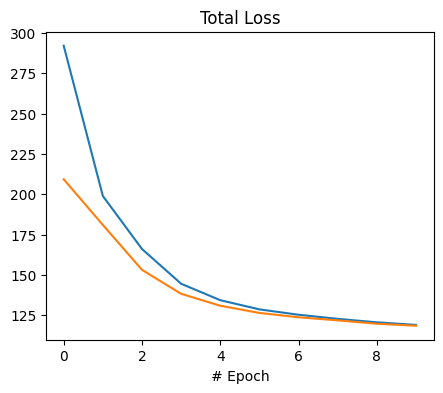

In [72]:
vae = VAE()
trainer = VAETrainer(vae, 1e-3, 128, 10, 1e-5)
# train
trainer.train(train_data, val_data)

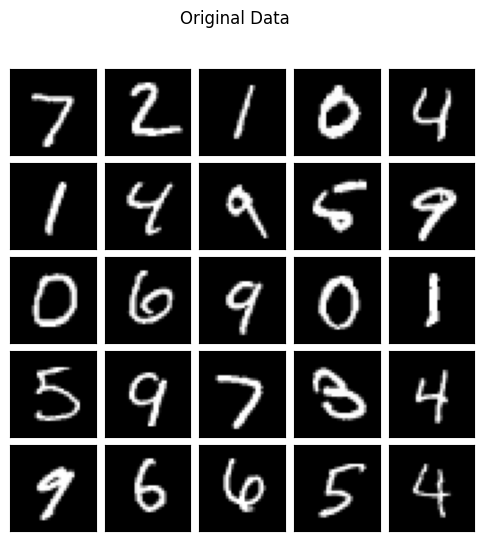

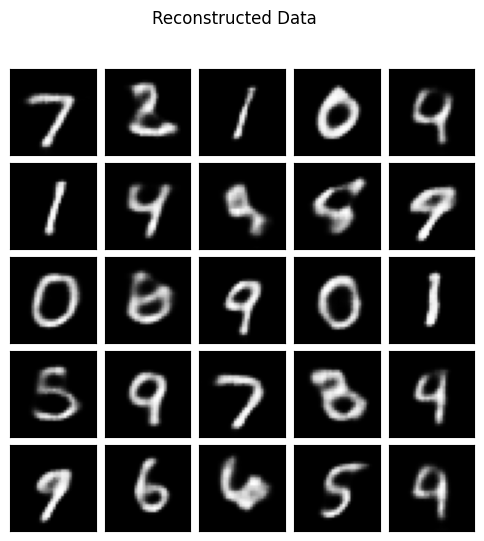

In [73]:
# evaulate the qualitiy of reconstruction
def plot_digits(data, title):
    fig, axes = plt.subplots(5, 5, figsize=(6, 6))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.suptitle(title)
    for i, ax in enumerate(axes.flatten()):
        im = ax.imshow(data[i].reshape(32, 32), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

def compare_reconstruct(model, X):
    plot_digits(X, "Original Data")
    with torch.no_grad():
        X_recon, _, _ = model(X)
    plot_digits(X_recon, "Reconstructed Data")


compare_reconstruct(trainer.model, X_test[:100])

Reconstruction worked well! If I had more time to train on additional epochs, then reconstruction could potentially look even better!

# Question 2

In [157]:
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.utils import scatter

## (a)

In [158]:
def load_qm9(path="./QM9"):
    def transform(data):
        edge_index = torch.tensor(
            list(itertools.permutations(range(data.x.shape[0]), 2)), 
            dtype=torch.long
        ).T
        edge_feature = 1 / torch.sqrt(
            torch.sum(
                (data.pos[edge_index[0]] - data.pos[edge_index[1]]) ** 2, 
                axis=1, keepdim=True
            )
        )
        data.edge_index = edge_index
        data.edge_attr = edge_feature
        data.y = data.y[:, [-7]]
        return data
    
    qm9 = QM9(path, transform=transform)
    return qm9

qm9 = load_qm9("./QM9")
train_data, test_data = train_test_split(qm9, train_size=0.8, test_size=0.2) # use train_test_split to do the index

In [169]:
qm9[0].x.shape

torch.Size([5, 11])

In [170]:
qm9[0].edge_attr.shape

torch.Size([20, 1])

In [159]:
# find out the dimension of node input features
node_input_dim = 11
edge_input_dim = 1

## (b)

In [160]:
class Layer(nn.Module):
    """
    Basic layer, a linear layer with a ReLU activation 
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, out_dim), # linear layer
            nn.ReLU() # relu
        )
    
    def forward(self, x):
        return self.layers(x)
    
    
class MessagePassingLayer(nn.Module):
    """
    A message passing layer that updates nodes/edge features
    """
    def __init__(self, node_hidden_dim, edge_hidden_dim):
        super().__init__()
        # figure out the input/output dimension
        self.edge_net = Layer(2*node_hidden_dim + edge_hidden_dim, edge_hidden_dim)
        # figure out the input/output dimension
        self.node_net = Layer(node_hidden_dim + edge_hidden_dim, node_hidden_dim)
    
    def forward(self, node_features, edge_features, edge_index):
        """
        Update node and edge features
        
        Parameters
        ----------
        node_features: torch.Tensor
            Node features from the previous layer
        edge_features: torch.Tensor
            Edge features from the previous layer
        edge_index: torch.Tensor
            A sparse matrix (n_edge, 2) in which each column denotes node indices forming an edge
        """
        # concatnate previous edge features with node features forming the edge
        # hint: use edge_features[edge_index[0(or 1)]] to get node features forming the edge
        concate_edge_features = torch.cat([
            node_features[edge_index[0]], # features of one node
            node_features[edge_index[1]], # features of the other node
            edge_features # previous edge features
        ], dim=1)
        
        # pass through the "edge_net" to map it back to the original dimension
        updated_edge_features = self.edge_net(concate_edge_features)
        
        
        # use scatter to aggrate the edge features to nodes
        aggr_edge_features = scatter(updated_edge_features, edge_index[0])
        # concatenate it with previous node features
        concate_node_features = torch.cat([aggr_edge_features, node_features], dim=1)
        # pass through the "node_net" to map it back to the original dimension
        updated_node_features = self.node_net(concate_node_features)
        
        return updated_node_features, updated_edge_features

        
class GraphNet(nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim):
        super().__init__()
        # embed the input node features
        self.node_embed = Layer(node_input_dim, node_hidden_dim)
        # embed the input edge features
        self.edge_embed = Layer(edge_input_dim, edge_hidden_dim)
        # message passing layer
        self.message_passing = MessagePassingLayer(node_hidden_dim, edge_hidden_dim)
        # use a linear layer as readout to get the "atomic" energy contribution
        self.readout = Layer(node_hidden_dim, 1)
        
    
    def forward(self, node_features, edge_features, edge_index, batch):
        """
        Update node and edge features
        
        Parameters
        ----------
        node_features: torch.Tensor
            Node features from the previous layer
        edge_features: torch.Tensor
            Edge features from the previous layer
        edge_index: torch.Tensor
            A sparse matrix (n_edges, 2) in which each column denotes node indices forming an edge
        batch: torch.Tensor
            A 1-D tensor (n_nodes,) that tells you each node belongs to which graph
        """
        node_hidden = self.node_embed(node_features) # call the node embedding
        edge_hidden = self.edge_embed(edge_features) # call the edge embedding
        updated_node_hidden, updated_edge_hidden = self.message_passing(node_hidden, edge_hidden, edge_index) # call the message passing layer
        readout = self.readout(updated_node_hidden) # use the readout layer to output "atomic" contributions
        out = scatter(readout, batch) # use the scatter function to aggregate atomic readouts
        return out

In [161]:
class GNNTrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        self.epoch = epoch
    
    def train(self, dataset, draw_curve=True):
        self.model.train()
        loader = GraphDataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        loss_func = nn.MSELoss()
        batch_loss_list = []
        for i in range(self.epoch):
            print(f"Epoch: {i}")
            for batch_data in tqdm(loader, leave=False):
                batch_size = batch_data.y.shape[0]
                batch_pred = self.model(batch_data.x, batch_data.edge_attr, batch_data.edge_index, batch_data.batch)
                batch_loss = loss_func(batch_pred, batch_data.y)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                batch_loss_list.append(batch_loss.detach().numpy())
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(np.arange(len(batch_loss_list)), batch_loss_list)
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        return batch_loss_list
    
    def evaluate(self, dataset, draw_curve=True):
        self.model.eval()
        loader = GraphDataLoader(dataset, batch_size=self.batch_size)
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch_data in tqdm(loader, leave=False):
                batch_pred = self.model(batch_data.x, batch_data.edge_attr, batch_data.edge_index, batch_data.batch)
                y_pred.append(batch_pred.detach().numpy().flatten())
                y_true.append(batch_data.y.detach().numpy().flatten())
        
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        mse = np.mean((y_true - y_pred) ** 2)
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(y_true, y_pred, label=f"MSE: {mse:.2f}", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return mse
        

## (c)

In [162]:
node_hidden_dim = 64
edge_hidden_dim = 64

net = GraphNet(node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim)

In [163]:
loader = GraphDataLoader(test_data, batch_size=512)
loader_iter = iter(loader)

In [164]:
batch_data = next(loader_iter)
batch_data.y

tensor([[ -70.4864],
        [ -75.7974],
        [ -79.6356],
        [ -93.8650],
        [ -74.7377],
        [ -87.3666],
        [ -83.9652],
        [ -80.5365],
        [ -72.0014],
        [ -60.1266],
        [ -75.0548],
        [ -75.2168],
        [ -89.5242],
        [ -61.2288],
        [ -78.6524],
        [ -75.2447],
        [ -86.2708],
        [ -75.7737],
        [ -73.5429],
        [ -68.3996],
        [ -66.4798],
        [ -88.5515],
        [ -73.5441],
        [ -66.5256],
        [ -75.8396],
        [ -87.3322],
        [ -75.0089],
        [ -67.5386],
        [ -75.9805],
        [ -81.8090],
        [ -77.1845],
        [ -89.2092],
        [ -78.3847],
        [ -74.4109],
        [ -87.7866],
        [ -77.0461],
        [ -71.6219],
        [ -82.8159],
        [ -58.8180],
        [ -74.6424],
        [ -87.5544],
        [ -77.9297],
        [ -57.6477],
        [ -93.9125],
        [ -65.6367],
        [ -97.0705],
        [ -85.6746],
        [ -95

In [165]:
batch_pred = net(batch_data.x, batch_data.edge_attr, batch_data.edge_index, batch_data.batch)
batch_pred

tensor([[19.1684],
        [17.9427],
        [23.0643],
        [30.7166],
        [18.7136],
        [26.9141],
        [24.4820],
        [25.4380],
        [19.4917],
        [12.3360],
        [22.1620],
        [17.9877],
        [32.6588],
        [12.9678],
        [19.7037],
        [21.3127],
        [26.9698],
        [20.8378],
        [21.3007],
        [17.8954],
        [16.2375],
        [25.9707],
        [17.1623],
        [16.9777],
        [21.2631],
        [29.0107],
        [18.7519],
        [18.6176],
        [20.4353],
        [26.0143],
        [19.1760],
        [29.0234],
        [22.1520],
        [22.1093],
        [29.0131],
        [23.5389],
        [18.3152],
        [24.5618],
        [13.6811],
        [19.9675],
        [26.4476],
        [23.6245],
        [11.6114],
        [30.6554],
        [15.9336],
        [36.7241],
        [26.9584],
        [30.6050],
        [16.2216],
        [30.6699],
        [21.7765],
        [21.2820],
        [23.

In [166]:
loss_func = nn.MSELoss()
loss_func(batch_pred, batch_data.y)

tensor(9634.5879, grad_fn=<MseLossBackward0>)

GraphNet - Number of parameters: 21569
Epoch: 0


Epoch: 1


Epoch: 2


[array(9736.492, dtype=float32),
 array(6316.7534, dtype=float32),
 array(5924.873, dtype=float32),
 array(5907.2515, dtype=float32),
 array(5884.923, dtype=float32),
 array(5787.246, dtype=float32),
 array(5792.818, dtype=float32),
 array(5887.7734, dtype=float32),
 array(5865.004, dtype=float32),
 array(5804.1816, dtype=float32),
 array(5869.4536, dtype=float32),
 array(5805.659, dtype=float32),
 array(6018.964, dtype=float32),
 array(5907.6255, dtype=float32),
 array(5914.883, dtype=float32),
 array(5850.363, dtype=float32),
 array(5946.798, dtype=float32),
 array(5932.56, dtype=float32),
 array(5940.7495, dtype=float32),
 array(5983.2334, dtype=float32),
 array(5883.205, dtype=float32),
 array(5845.581, dtype=float32),
 array(5790.1074, dtype=float32),
 array(5913.377, dtype=float32),
 array(5867.625, dtype=float32),
 array(5912.2925, dtype=float32),
 array(5891.485, dtype=float32),
 array(5914.533, dtype=float32),
 array(5881.984, dtype=float32),
 array(5894.752, dtype=float32),
 

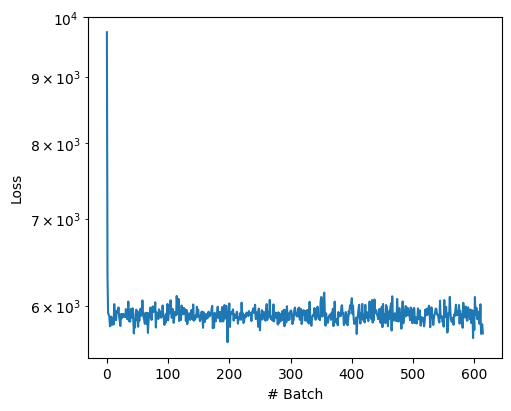

In [167]:
# 1e-3, 128, 10, 1e-5

# train
learning_rate = 1e-3
n_epoch = 3
batch_size = 512
l2 = 1e-5

trainer = GNNTrainer(net, batch_size, learning_rate, n_epoch, l2)
trainer.train(train_data)

5893.482

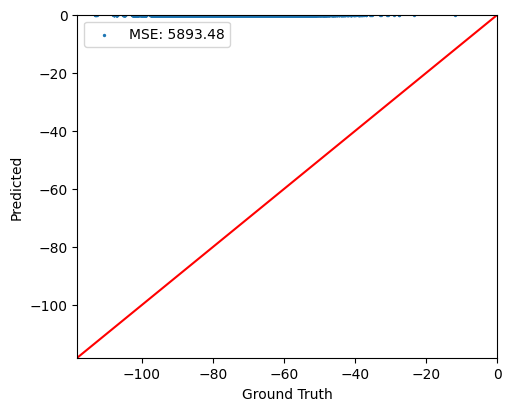

In [168]:
# evaulate
trainer.evaluate(test_data)

It appears that the MSE is quite large, as we are always predicting a slightly positive enthalpy of formation, versus the true enthalpy of formations being negative.